In [6]:
import pymysql
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import scipy.stats as stats
import csv
import matplotlib.colors as mcolors
import os

from statsmodels.stats.multicomp import MultiComparison

# from tidy_data import get_df_afr 
# afr.to_numpy()[1][0:4]

In [7]:
#csv
# afr = pd.read_csv('avaliacao_funcao_renal.csv')

In [8]:
con = pymysql.connect(host="localhost", user="gabic", passwd="1234", db="doenca_renal_cronica")
con.select_db('doenca_renal_cronica')
cursor = con.cursor()  
cursor.connection.autocommit(True)

In [9]:
#criando os dataframes por tabela 
dados_consulta = pd.read_sql('SELECT * FROM doenca_renal_cronica.dados_consulta',con=con)
cidade = pd.read_sql('SELECT * FROM doenca_renal_cronica.cidade',con=con)
ubs = pd.read_sql('SELECT * FROM doenca_renal_cronica.ubs',con=con)
aval_funcao_renal = pd.read_sql('SELECT * FROM doenca_renal_cronica.aval_funcao_renal',con=con)
consulta_has = pd.read_sql('SELECT * FROM doenca_renal_cronica.consulta_has',con=con)
consulta_drc = pd.read_sql('SELECT * FROM doenca_renal_cronica.consulta_drc',con=con)
consulta_dm = pd.read_sql('SELECT * FROM doenca_renal_cronica.consulta_dm',con=con)
calculo_tfg = pd.read_sql('SELECT * FROM doenca_renal_cronica.calculo_tfg',con=con)
preparacao_trs = pd.read_sql('SELECT * FROM doenca_renal_cronica.preparacao_trs',con=con)
raca = pd.read_sql('SELECT * FROM doenca_renal_cronica.raca',con=con)
instrucao = pd.read_sql('SELECT * FROM doenca_renal_cronica.instrucao',con=con)
paciente = pd.read_sql('SELECT * FROM doenca_renal_cronica.paciente',con=con)
exame_fisico = pd.read_sql('SELECT * FROM doenca_renal_cronica.exame_fisico',con=con)
avaliacao_tratamento = pd.read_sql('SELECT * FROM doenca_renal_cronica.avaliacao_tratamento',con=con)
medicamento = pd.read_sql('SELECT * FROM doenca_renal_cronica.medicamento',con=con)
complicacao_funcao_renal = pd.read_sql('SELECT * FROM doenca_renal_cronica.complicacao_funcao_renal',con=con)

#dicionario com todas tabelas
dic = {'dados_consulta':dados_consulta,'cidade':cidade,'ubs':ubs,'aval_funcao_renal':aval_funcao_renal,
       'consulta_has':consulta_has,'consulta_drc':consulta_drc,'consulta_dm':consulta_dm,'calculo_tfg':calculo_tfg,
       'preparacao_trs':preparacao_trs,'raca':raca,'instrucao':instrucao,'paciente':paciente,'exame_fisico':exame_fisico,
       'avaliacao_tratamento':avaliacao_tratamento,'medicamento':medicamento,'complicacao_funcao_renal':complicacao_funcao_renal
      }

In [10]:
correto={}
meses = ['jan','fev','mar','abr','mai','jun','jul','ago','set','out','nov','dez']
for ind in range(len(dic['aval_funcao_renal']['id_afr'])):
    if dic['paciente']['data_nascimento'][ind]!='0.0':
        data_nascimento = dic['paciente']['data_nascimento'][ind].split('/')
#         correto['dia'] = data_nascimento[0]
        for i in range(len(meses)):
            if meses[i]==data_nascimento[1]:
                tam = len(meses[0:i])
#         correto['mes'] = tam+1
#         correto['ano'] = data_nascimento[2]
        correto = str(1900+int(data_nascimento[2]))+'-'+str(tam+1)+'-'+data_nascimento[0]
        dic['paciente']['data_nascimento'][ind] = pd.to_datetime(correto)
#     print(str(ind))

/home/gabic9814/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [11]:
#substituindo os valores para Nan 
for tabela in dic:
    for coluna in dic[tabela].keys():
        dic[tabela][coluna]=dic[tabela][coluna].replace([0,'0','0.0',''], np.nan)

In [12]:
for tabela in dic:
    for coluna in dic[tabela].keys():
        i_split = coluna.split('_')
        if i_split[0]=='id':
            dic[tabela]=dic[tabela].drop(columns=[coluna], errors='ignore')
        if i_split[0]=='dt':
            dic[tabela]=dic[tabela].drop(columns=[coluna], errors='ignore')
        if i_split[0]=='total':
            dic[tabela]=dic[tabela].drop(columns=[coluna], errors='ignore')

In [13]:
afr={}
cfr={}
data = pd.read_csv('banco/Dados2010-2014DesfechoFasesETC2.csv')
idade = data['Idade']
id_paciente = data['Id']
for tabela in dic:
    for coluna in dic[tabela].keys():
        if coluna == 'sexo' or coluna=='data_nascimento' or coluna =='estagioI' or coluna=='estagioF' or coluna=='estagioI_alb' or coluna=='estagioF_alb':
            afr[coluna] = dic[tabela][coluna]
            cfr[coluna] = dic[tabela][coluna]
        elif tabela == 'aval_funcao_renal':
            afr[coluna] = dic[tabela][coluna]
        elif tabela == 'complicacao_funcao_renal':
            cfr[coluna] = dic[tabela][coluna]
            
afr['id_paciente'] = id_paciente
cfr['id_paciente'] = id_paciente      
afr['idade'] = idade
cfr['idade'] = idade
df_afr = pd.DataFrame(afr)
df_cfr = pd.DataFrame(cfr)

/home/gabic9814/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (214,222,223,229) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
#tidy data
df_afr=(df_afr.melt(id_vars=["id_paciente","sexo","idade","data_nascimento","estagioI", "estagioF", 'estagioI_alb', 'estagioF_alb'],
                    var_name=["exame"],
                    value_name="valor"))

In [53]:
colors = mcolors.CSS4_COLORS
colors

{'aquamarine': '#7FFFD4',
 'black': '#000000',
 'blue': '#0000FF',
 'blueviolet': '#8A2BE2',
 'brown': '#A52A2A',
 'burlywood': '#DEB887',
 'cadetblue': '#5F9EA0',
 'chartreuse': '#7FFF00',
 'chocolate': '#D2691E',
 'coral': '#FF7F50',
 'cornflowerblue': '#6495ED',
 'crimson': '#DC143C',
 'cyan': '#00FFFF',
 'darkblue': '#00008B',
 'darkcyan': '#008B8B',
 'darkgoldenrod': '#B8860B',
 'darkgray': '#A9A9A9',
 'darkgreen': '#006400',
 'darkkhaki': '#BDB76B',
 'darkmagenta': '#8B008B',
 'darkolivegreen': '#556B2F',
 'darkorange': '#FF8C00',
 'darkorchid': '#9932CC',
 'darkred': '#8B0000',
 'darksalmon': '#E9967A',
 'darkseagreen': '#8FBC8F',
 'darkslateblue': '#483D8B',
 'darkslategray': '#2F4F4F',
 'darkslategrey': '#2F4F4F',
 'darkturquoise': '#00CED1',
 'darkviolet': '#9400D3',
 'deeppink': '#FF1493',
 'deepskyblue': '#00BFFF',
 'dimgray': '#696969',
 'dodgerblue': '#1E90FF',
 'firebrick': '#B22222',
 'forestgreen': '#228B22',
 'fuchsia': '#FF00FF',
 'gold': '#FFD700',
 'goldenrod': '#D

In [54]:
colors.pop('snow', None)
colors.pop('grey', None)
colors.pop('white', None)
colors.pop('whitesmoke', None)
colors.pop('gainsboro', None)
colors.pop('lightgrey', None)
colors.pop('darkgrey', None)
colors.pop('dimgrey', None)
colors.pop('seashell', None)
colors.pop('peachpuff', None)
colors.pop('linen', None)
colors.pop('bisque', None)
colors.pop('tan', None)
colors.pop('antiquewhite', None)
colors.pop('navajowhite', None)
colors.pop('blanchedalmond', None)
colors.pop('oldlace', None)
colors.pop('floralwhite', None)
colors.pop('papayawhip', None)
colors.pop('cornsilk', None)
colors.pop('lemonchiffon', None)
colors.pop('ivory', None)
colors.pop('beige', None)
colors.pop('lightyellow', None)
colors.pop('lightoldenrodyellow', None)
colors.pop('honeydew', None)
colors.pop('mintcream', None)
colors.pop('moccasin', None)
colors.pop('wheat', None)
colors.pop('palegoldenrod', None)
colors.pop('palegreen', None)
colors.pop('azure', None)
colors.pop('ligtcyan', None)
colors.pop('aliceblue', None)
colors.pop('ghostwhite', None)
colors.pop('lavender', None)
colors.pop('lavenderbrush', None)
colors.pop('aqua', None)
colors.pop('ligtsalmon', None)

/home/gabic9814/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/gabic9814/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/gabic9814/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/gabic9814/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/gabic9814/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/gabic9814/anaconda3/lib/python3

/home/gabic9814/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/gabic9814/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/gabic9814/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/gabic9814/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/gabic9814/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/gabic9814/anaconda3/lib/python3

/home/gabic9814/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/gabic9814/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/gabic9814/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/gabic9814/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/gabic9814/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde

/home/gabic9814/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/gabic9814/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/gabic9814/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/gabic9814/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/gabic9814/anaconda3/lib/p

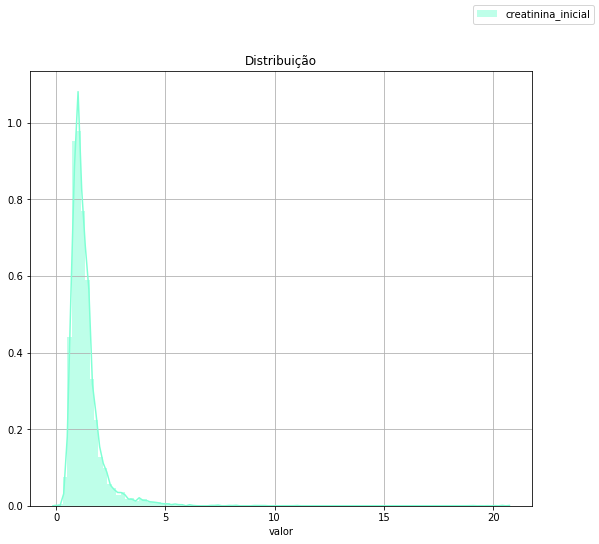

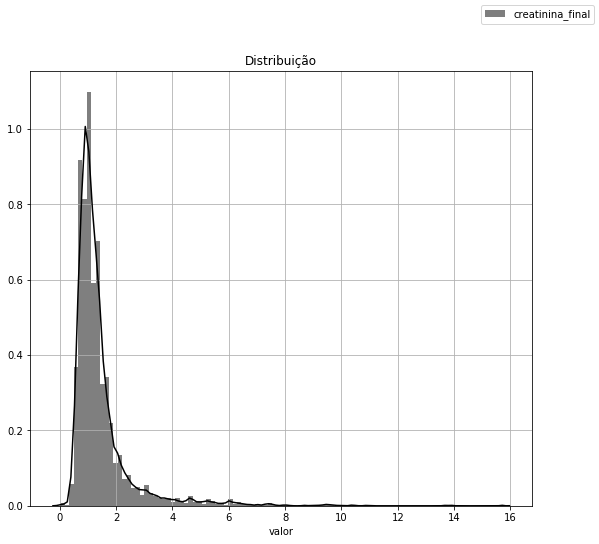

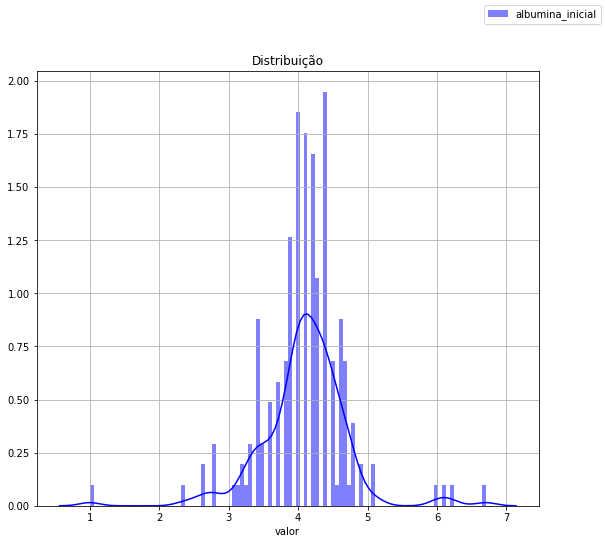

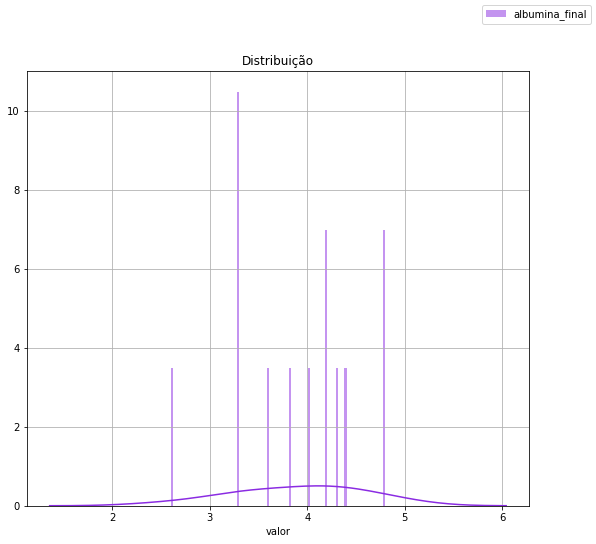

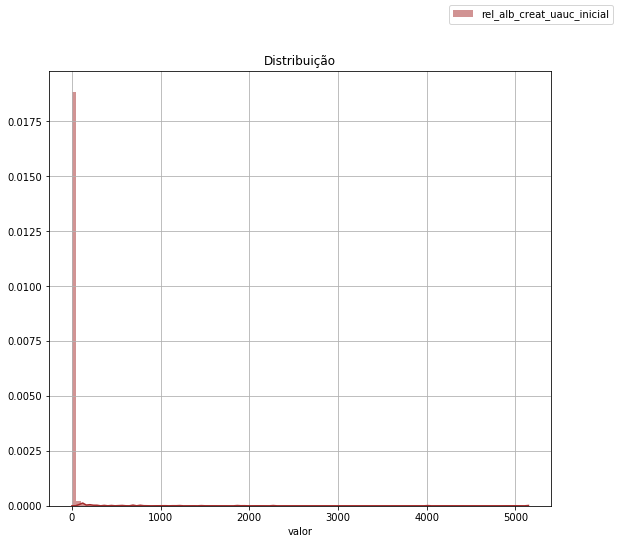

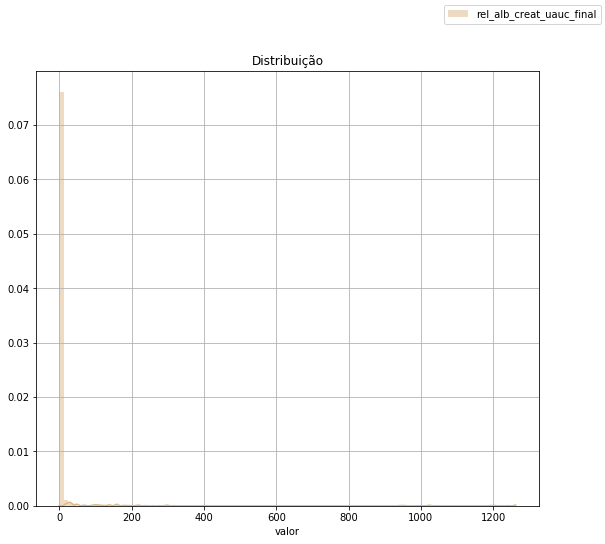

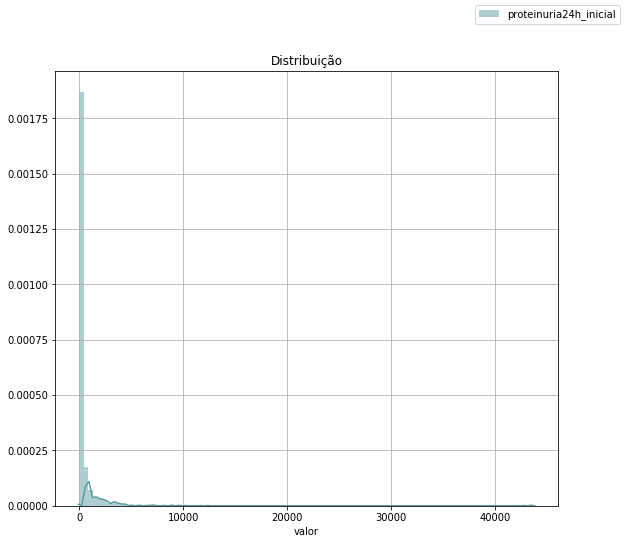

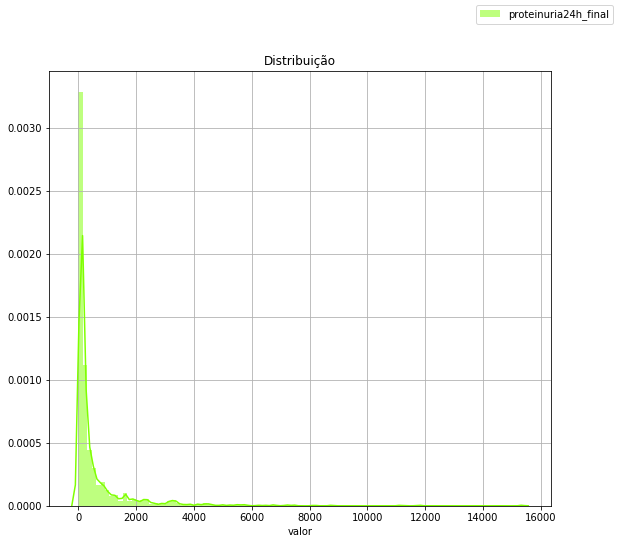

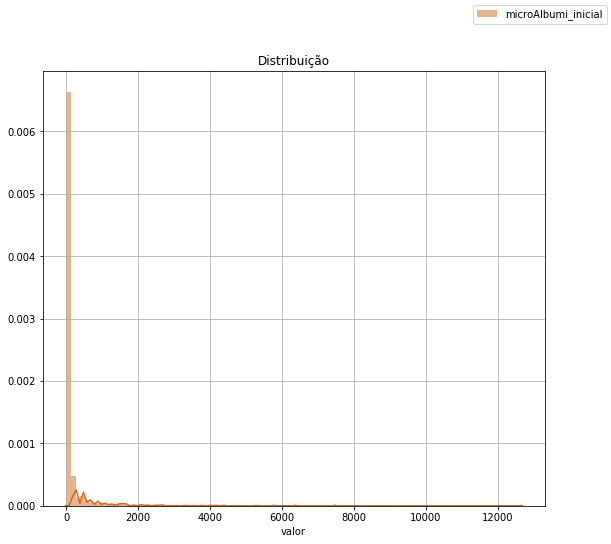

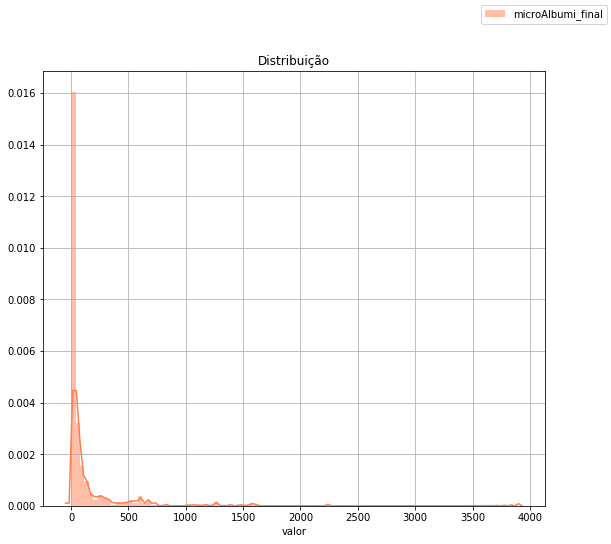

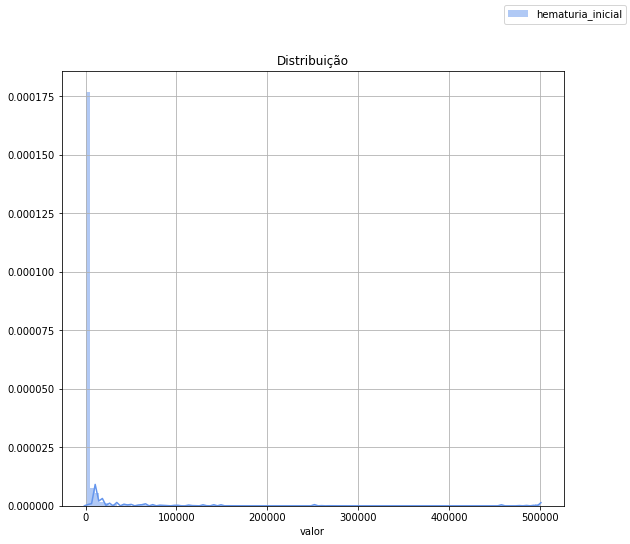

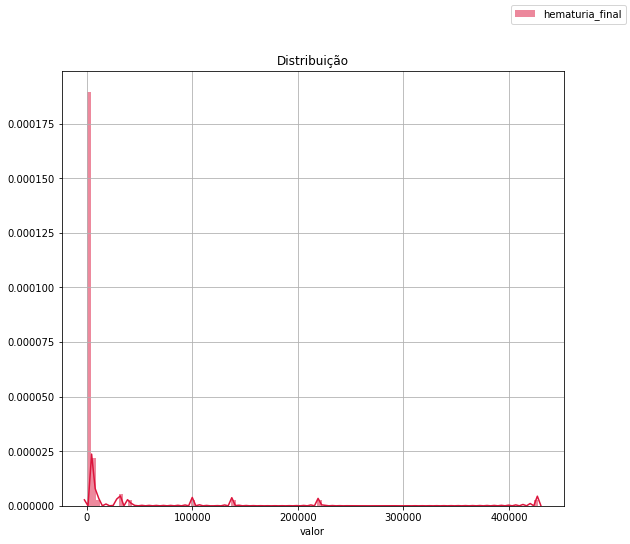

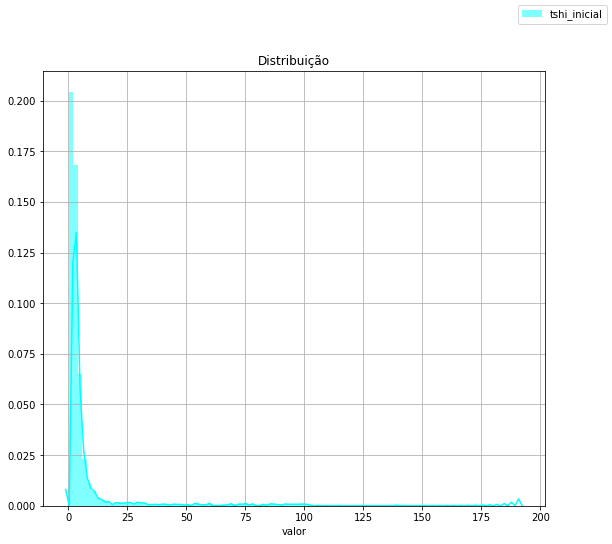

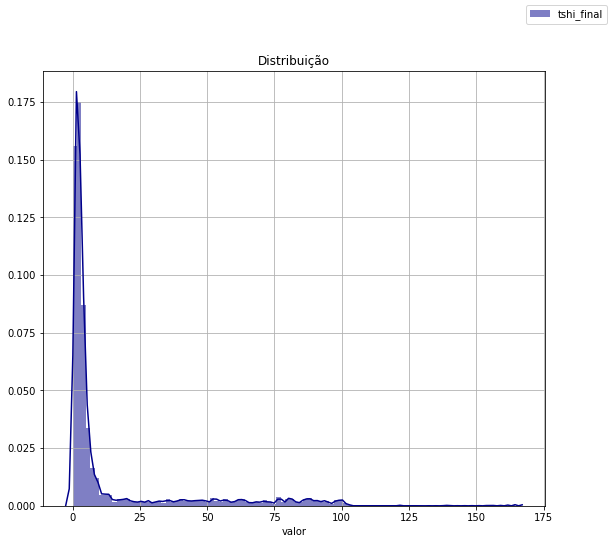

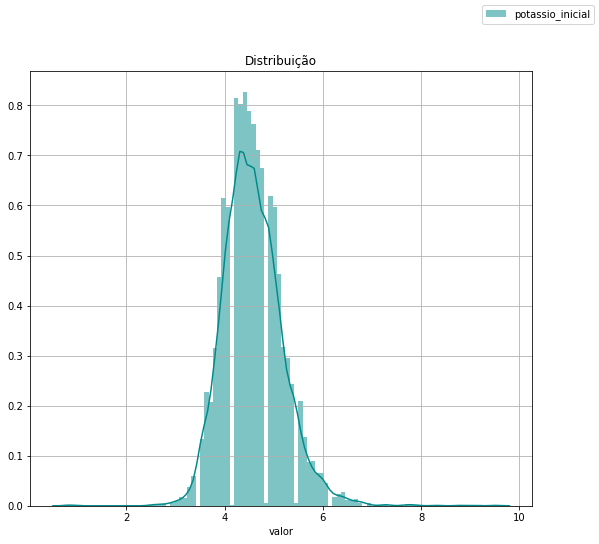

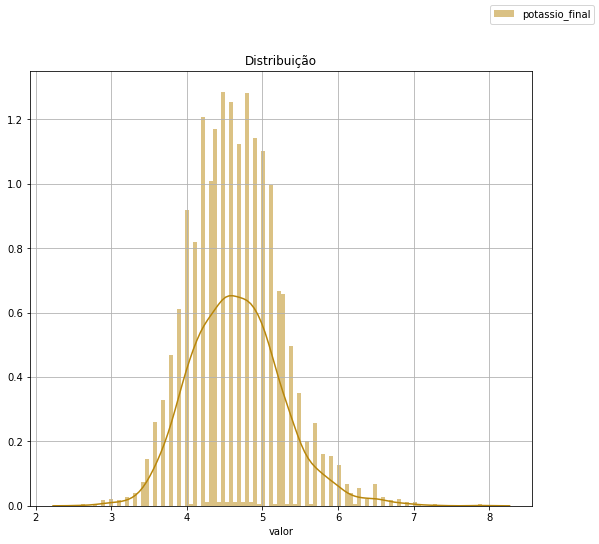

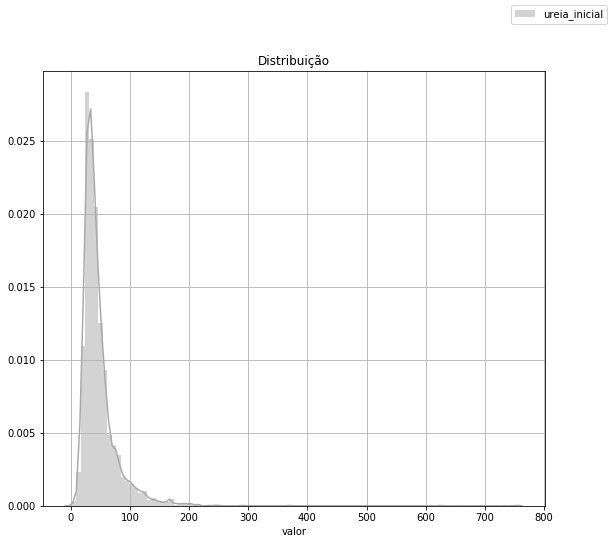

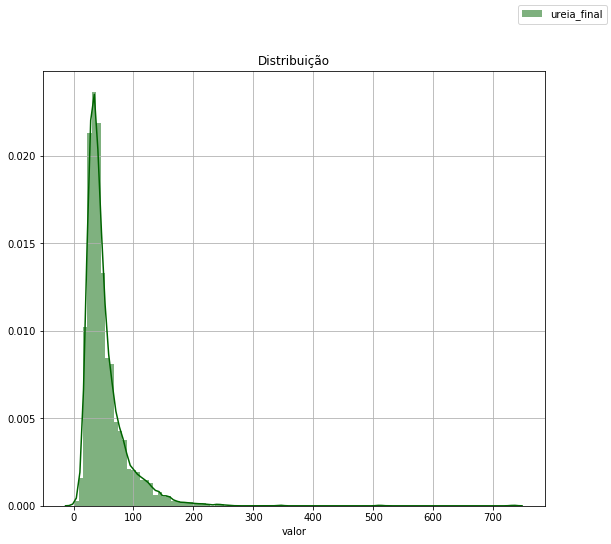

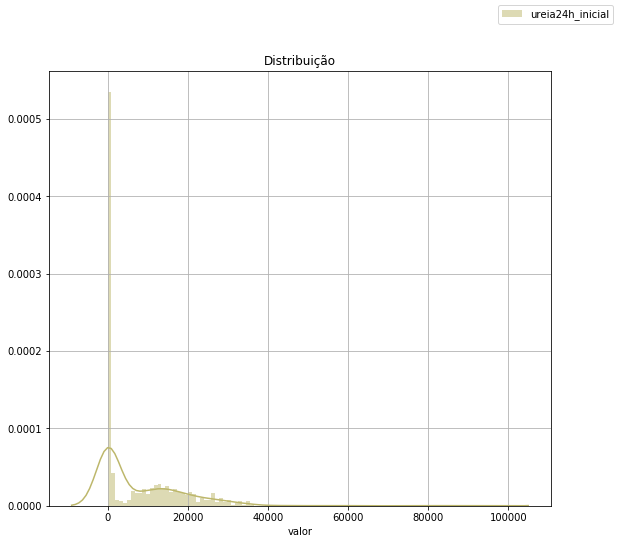

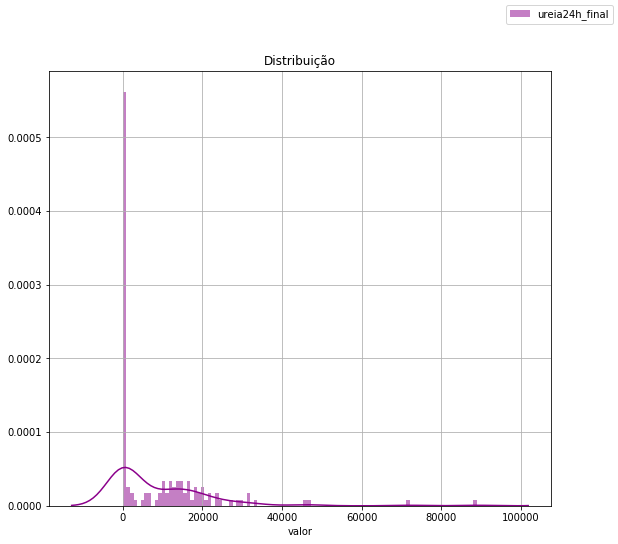

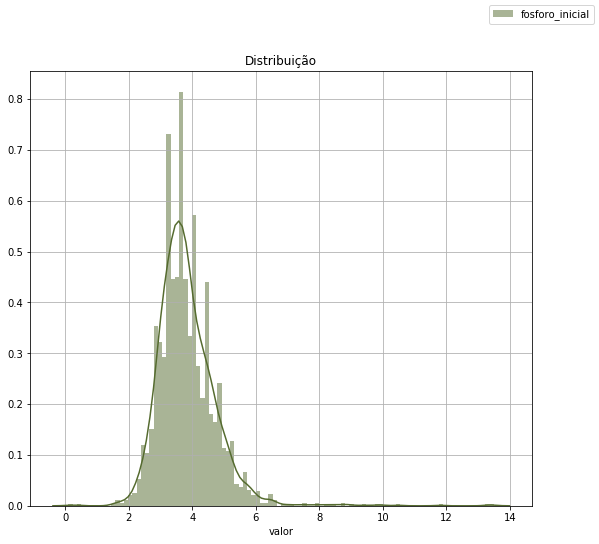

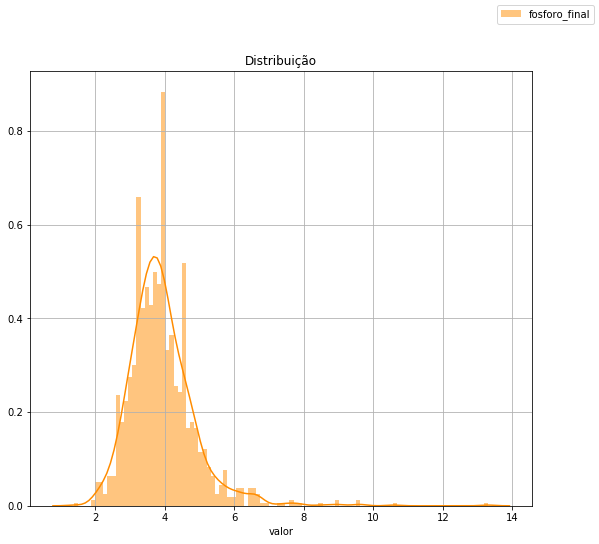

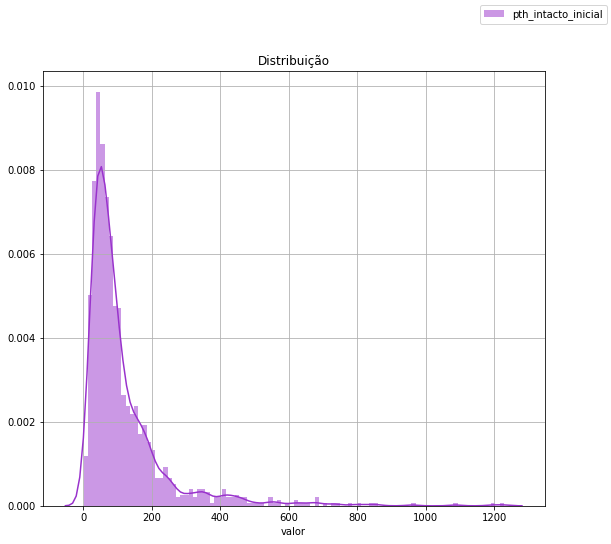

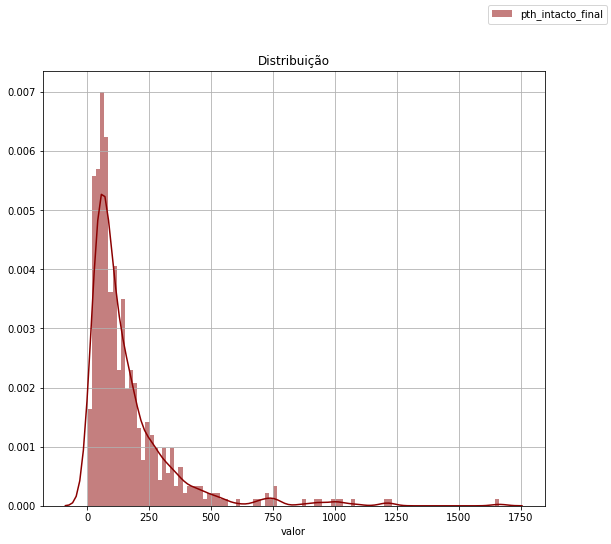

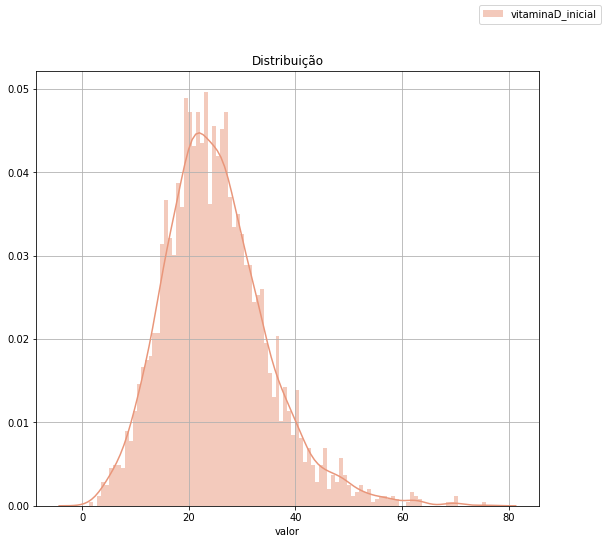

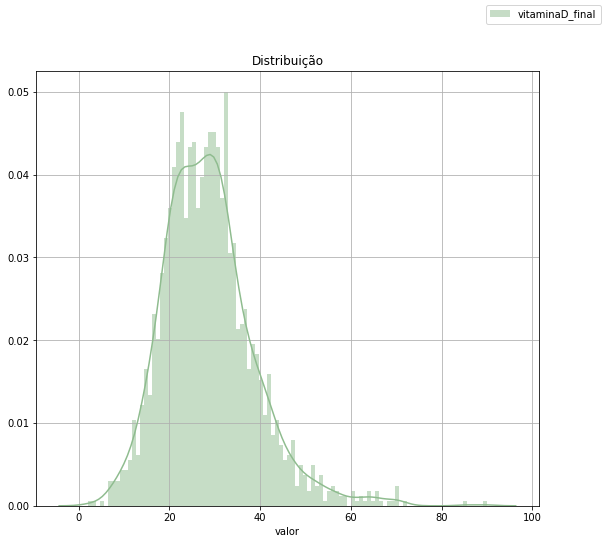

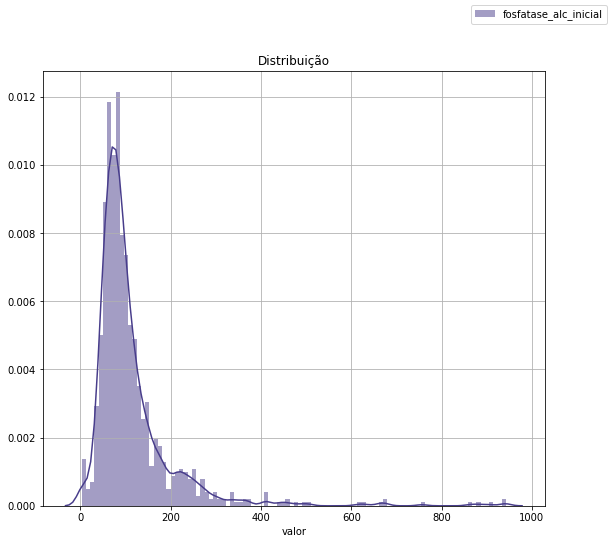

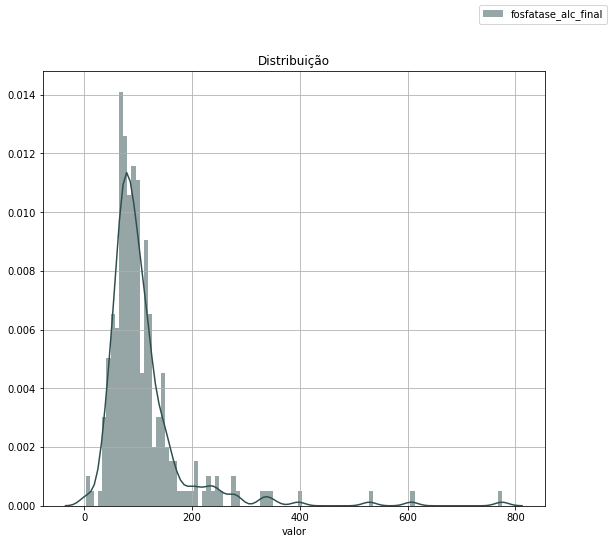

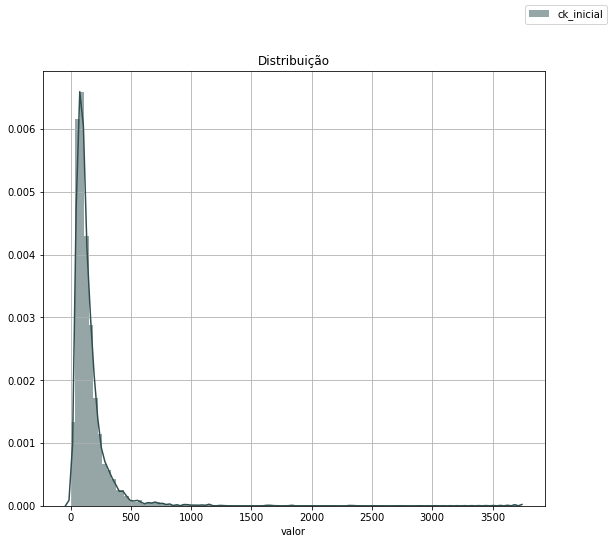

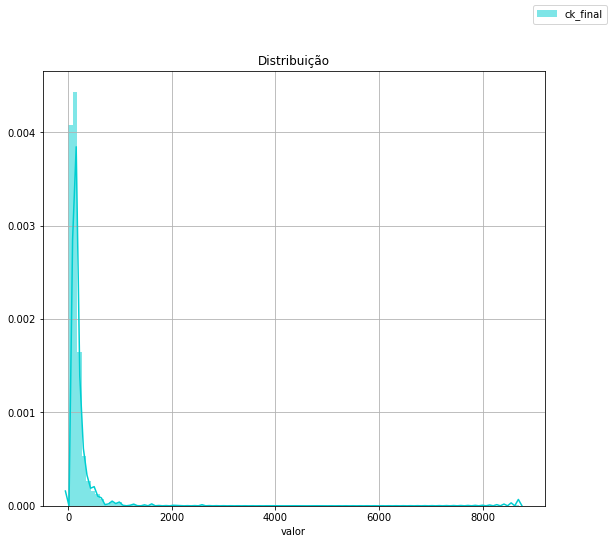

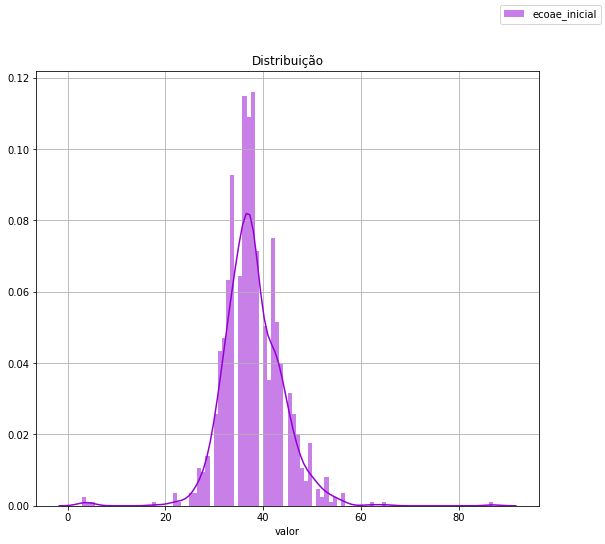

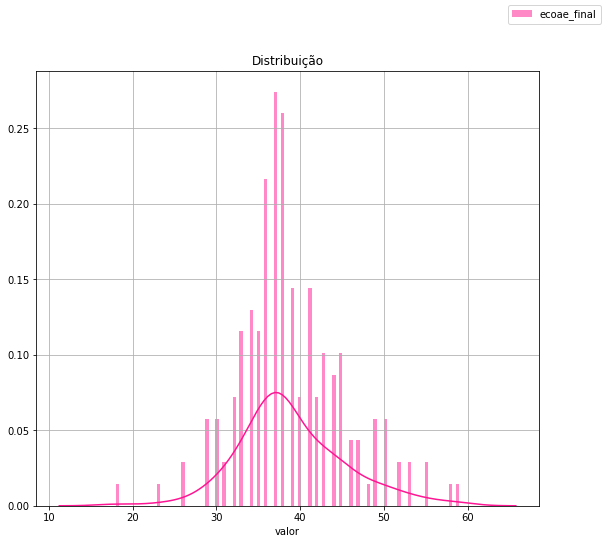

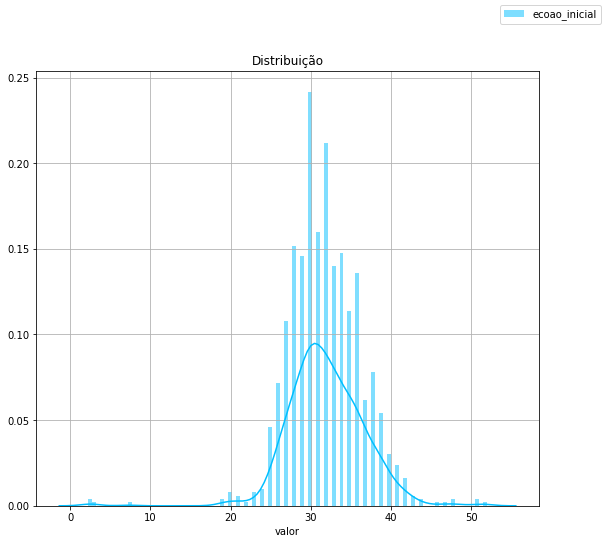

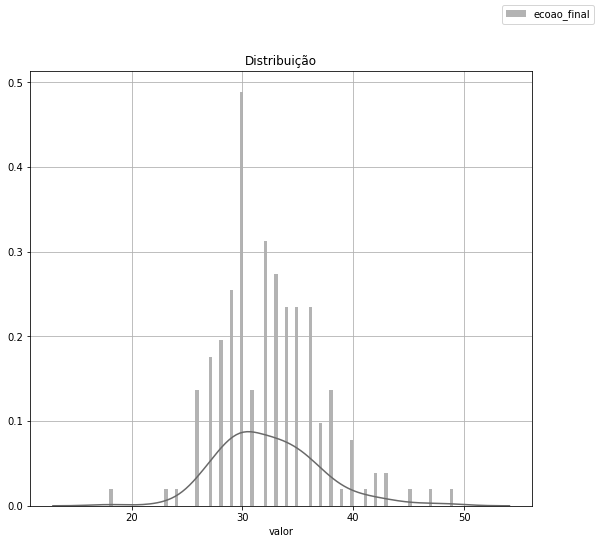

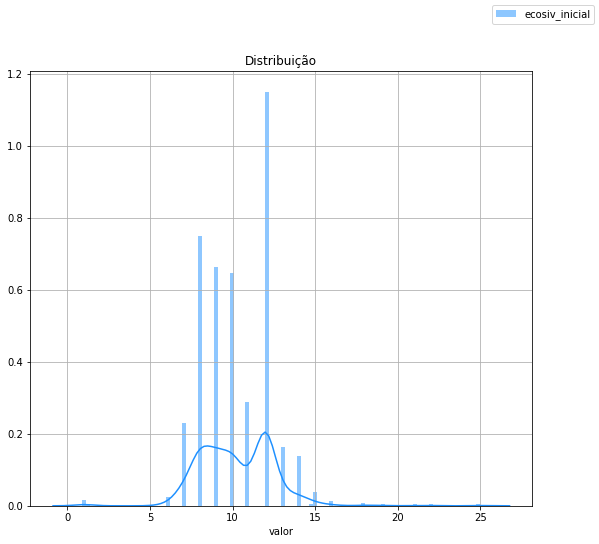

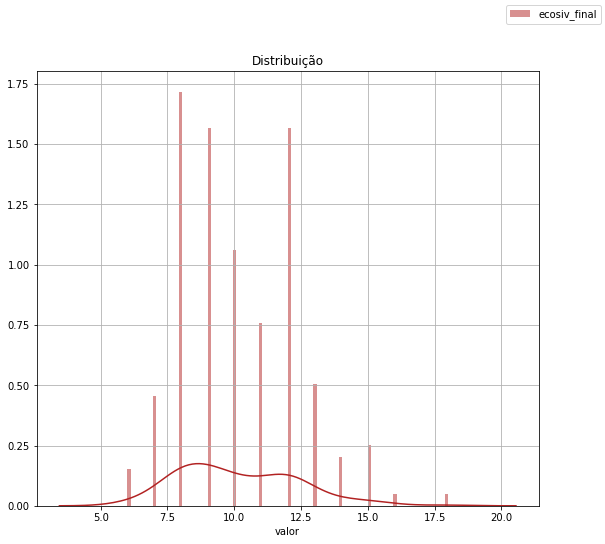

In [55]:
# colors = ['#1f77b4',
#           '#ff7f0e',
#           '#2ca02c',
#           '#d62728',
#           '#9467bd',
#           '#8c564b',
#           '#e377c2',
#           '#7f7f7f',
#           '#bcbd22',
#           '#17becf',
#           '#1a55FF']
colors=list(colors)
nomes_exames =['creatinina_inicial', 'creatinina_final', 'albumina_inicial',
               'albumina_final', 'rel_alb_creat_uauc_inicial',
               'rel_alb_creat_uauc_final', 'proteinuria24h_inicial',
               'proteinuria24h_final', 'microAlbumi_inicial', 'microAlbumi_final',
               'hematuria_inicial', 'hematuria_final', 'tshi_inicial', 'tshi_final',
               'potassio_inicial', 'potassio_final', 'ureia_inicial', 'ureia_final',
               'ureia24h_inicial', 'ureia24h_final', 'fosforo_inicial',
               'fosforo_final', 'pth_intacto_inicial', 'pth_intacto_final',
               'vitaminaD_inicial', 'vitaminaD_final', 'fosfatase_alc_inicial',
               'fosfatase_alc_final', 'ck_inicial', 'ck_final', 'ecoae_inicial',
               'ecoae_final', 'ecoao_inicial', 'ecoao_final', 'ecosiv_inicial',
               'ecosiv_final']
# os.mkdir('/home/gabic9814/git/DRC/distribuicao_banco')
for ind in range(len(nomes_exames)):
    fig = plt.figure(figsize=(9, 8))
    plt.grid()
    plt.title('Distribuição')
    sns.distplot(df_afr.loc[df_afr['exame'] == nomes_exames[ind], 'valor'], color=colors[ind], bins=100, hist_kws={'alpha': 0.5});
#     sns.distplot(df_afr.loc[df_afr['exame'] == 'albumina_inicial', 'valor'], color=colors[1], bins=100, hist_kws={'alpha': 0.5});
    # sns.distplot(df_afr.loc[df_afr['exame'] == 'creatinina_final', 'valor'], color=colors[2], bins=100, hist_kws={'alpha': 0.5});
    # sns.distplot(df_afr.loc[df_afr['exame'] == 'creatinina_inicial', 'valor'], color=colors[3], bins=100, hist_kws={'alpha': 0.5});
    fig.legend([nomes_exames[ind],],loc='upper right')
    # plt.show()
#     ,'albumina_inicial'
    plt.savefig("distribuicao_banco/Distribuicao_"+str(nomes_exames[ind]))

In [ ]:
#  sns.distplot(afr.loc[afr['exame'] == nomes_exames[ind], 'valor'], color=colors[ind+10], bins=100, hist_kws={'alpha': 0.5});

In [56]:
type(df_afr.loc[df_afr['exame'] == nomes_exames[ind], 'valor'])

pandas.core.series.Series

In [59]:
df_afr

,id_paciente,sexo,idade,data_nascimento,estagioI,estagioF,estagioI_alb,estagioF_alb,exame,valor
0,20,Feminino,34.0,1979-08-04,NaN,NaN,NaN,NaN,creatinina_inicial,0.83
1,27,Masculino,74.0,1940-05-29,3a,2,1.0,NaN,creatinina_inicial,1.40
2,28,Feminino,72.0,1941-09-14,NaN,NaN,NaN,NaN,creatinina_inicial,NaN
3,29,Masculino,79.0,1934-12-21,NaN,NaN,NaN,NaN,creatinina_inicial,NaN
4,31,Feminino,69.0,1944-12-05,NaN,NaN,NaN,NaN,creatinina_inicial,NaN
5,32,Masculino,56.0,1957-10-24,NaN,NaN,NaN,NaN,creatinina_inicial,NaN
6,33,Feminino,70.0,1943-12-12,NaN,NaN,NaN,NaN,creatinina_inicial,NaN
7,35,Feminino,50.0,1964-03-26,3a,3a,1.0,1.0,creatinina_inicial,0.60
8,40,Feminino,78.0,1937-04-21,4,3b,NaN,2.0,creatinina_inicial,2.10
9,41,Masculino,65.0,1948-04-17,NaN,NaN,NaN,NaN,creatinina_inicial,NaN


In [61]:
df_afr.describe()

,id_paciente,idade,estagioI_alb,estagioF_alb,valor
count,261576.000000,261144.000000,89352.000000,76788.000000,67631.000000
mean,4771.090008,61.402537,1.433924,1.383497,248.954200
std,2790.477965,14.395198,0.516321,0.487204,4844.377229
min,20.000000,4.000000,1.000000,1.000000,0.010000
25%,2321.000000,53.000000,1.000000,1.000000,2.270000
50%,4712.500000,62.000000,1.000000,1.000000,6.400000
75%,7260.000000,71.000000,2.000000,2.000000,45.000000
max,9837.000000,102.000000,3.000000,3.000000,500000.000000


In [64]:
for ind in range(len(nomes_exames)):
    print('Tabela que está sendo analisada:'+ nomes_exames[ind])
    print(df_afr.loc[df_afr['exame'] == nomes_exames[ind], 'valor'].describe())       
    print('\n')

Tabela que está sendo analisada:creatinina_inicial
count    6115.000000
mean        1.328741
std         0.817987
min         0.100000
25%         0.900000
50%         1.120000
75%         1.500000
max        20.500000
Name: valor, dtype: float64


Tabela que está sendo analisada:creatinina_final
count    4555.000000
mean        1.424654
std         1.111397
min         0.020000
25%         0.890000
50%         1.100000
75%         1.500000
max        15.700000
Name: valor, dtype: float64


Tabela que está sendo analisada:albumina_inicial
count    180.000000
mean       4.095556
std        0.626971
min        1.000000
25%        3.875000
50%        4.100000
75%        4.400000
max        6.700000
Name: valor, dtype: float64


Tabela que está sendo analisada:albumina_final
count    13.000000
mean      3.896154
std       0.651224
min       2.600000
25%       3.300000
50%       4.020000
75%       4.300000
max       4.800000
Name: valor, dtype: float64


Tabela que está sendo analisada:rel_

In [69]:
with open ('descricao_afr.txt','w') as arquivo:
    for ind in range(len(nomes_exames)):
        arquivo.write('Nome:'+ nomes_exames[ind]+'\n')
        arquivo.write(str(df_afr.loc[df_afr['exame'] == nomes_exames[ind], 'valor'].describe()))       
        arquivo.write('\n')
